# Artem Moskalev. Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb
- homework_differentiation.ipynb

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm_notebook
from copy import deepcopy
from sklearn.decomposition import PCA

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

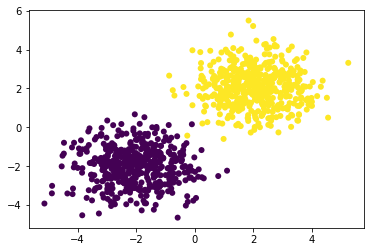

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none');

Define a **logistic regression** for debugging. 

In [5]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [7]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

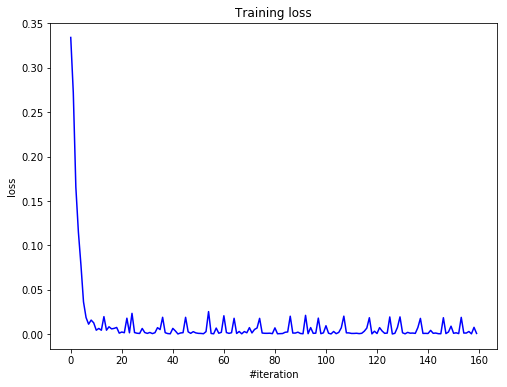

Current loss: 0.000885


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

 - ##### Let's try another architecture:

In [9]:
# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())
print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



In [10]:
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

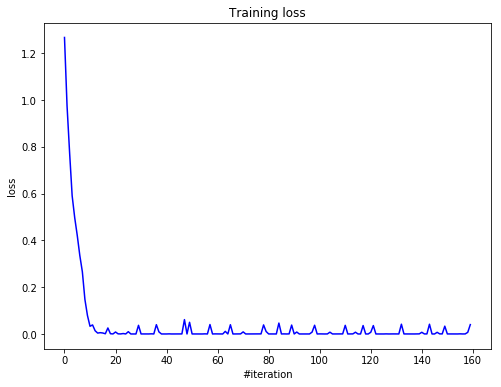

Current loss: 0.040069


In [11]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

It works. Cheers!

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [12]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

One-hot encode the labels first.

In [13]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
Y = np.array(ohe.fit_transform(y.reshape(-1,1)).todense())

In [14]:
Y.shape #check

(70000, 10)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

 - ##### First we want to just test all networks with different activations:

P.S. I will not use time library for time calculations, instead I suggest to use tqdm, which will provide us with iteration counter with time.

In [15]:
# Your code goes here. ################################################
n_epoch = 20
batch_size = 128

In [16]:
activations = [SoftPlus(), LeakyReLU(), ReLU(), ELU()]
loss_per_activation = list()

for each_activation in activations:
    
    net = Sequential()
    net.add(Linear(28*28, 500))
    net.add(each_activation)
    net.add(each_activation)
    net.add(each_activation)
    net.add(Linear(500, 10))
    net.add(LogSoftMax())
    
    optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
    optimizer_state = {}
    criterion = ClassNLLCriterion()
    
    loss_history = []

    for i in tqdm_notebook(range(n_epoch)):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_history.append(loss)
            
    loss_per_activation.append(loss_history)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

 - ##### Let's do all the same, but with BatchNormalization:

In [17]:
loss_per_activation_BN = list()

for each_activation in activations:
    
    net = Sequential()
    net.add(Linear(28*28, 500))
    net.add(BatchNormalization())
    net.add(ChannelwiseScaling(500))
    net.add(each_activation)
    net.add(each_activation)
    net.add(each_activation)
    net.add(Linear(500, 10))
    net.add(LogSoftMax())
    
    optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
    optimizer_state = {}
    criterion = ClassNLLCriterion()
    
    loss_history = []

    for i in tqdm_notebook(range(n_epoch)):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_history.append(loss)
            
    loss_per_activation_BN.append(loss_history)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

 - ##### Let's visualize all the stuff:

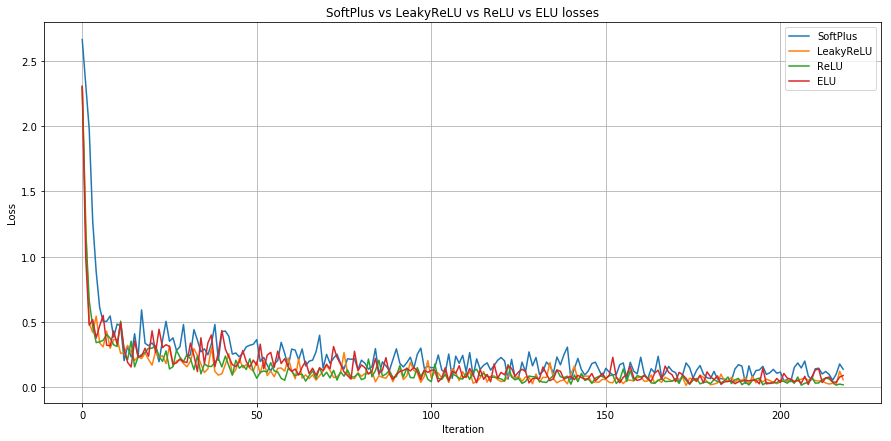

In [18]:
plt.figure(figsize=(15, 7))
plt.plot(loss_per_activation[0][::50], label = 'SoftPlus')
plt.plot(loss_per_activation[1][::50], label = 'LeakyReLU')
plt.plot(loss_per_activation[2][::50], label = 'ReLU')
plt.plot(loss_per_activation[3][::50], label = 'ELU')
plt.title('SoftPlus vs LeakyReLU vs ReLU vs ELU losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
#plt.yscale('log')
plt.grid()
plt.legend();

In [19]:
print('SoftPlus min Loss: ' +str(min(loss_per_activation[0])))
print('LeakyReLU min Loss: '+str(min(loss_per_activation[1])))
print('ReLU min Loss: '     +str(min(loss_per_activation[2])))
print('ELU min Loss: '     +str(min(loss_per_activation[3])))

SoftPlus min Loss: 0.0198469889282
LeakyReLU min Loss: 0.00675456391341
ReLU min Loss: 0.00846334886619
ELU min Loss: 0.00996556245694


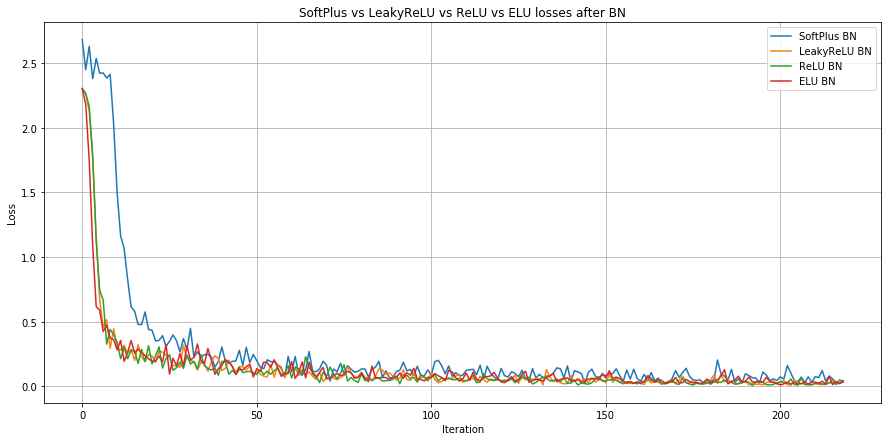

In [20]:
plt.figure(figsize=(15, 7))
plt.plot(loss_per_activation_BN[0][::50], label = 'SoftPlus BN')
plt.plot(loss_per_activation_BN[1][::50], label = 'LeakyReLU BN')
plt.plot(loss_per_activation_BN[2][::50], label = 'ReLU BN')
plt.plot(loss_per_activation_BN[3][::50], label = 'ELU BN')
plt.title('SoftPlus vs LeakyReLU vs ReLU vs ELU losses after BN')
plt.xlabel('Iteration')
plt.ylabel('Loss')
#plt.yscale('log')
plt.grid()
plt.legend();

In [21]:
print('SoftPlus + BN min Loss: ' +str(min(loss_per_activation_BN[0])))
print('LeakyReLU + BN min Loss: '+str(min(loss_per_activation_BN[1])))
print('ReLU + BN min Loss: '     +str(min(loss_per_activation_BN[2])))
print('ELU + BN min Loss: '     +str(min(loss_per_activation_BN[3])))

SoftPlus + BN min Loss: 0.00673991548251
LeakyReLU + BN min Loss: 0.00472716384952
ReLU + BN min Loss: 0.00565894951885
ELU + BN min Loss: 0.00707125750441


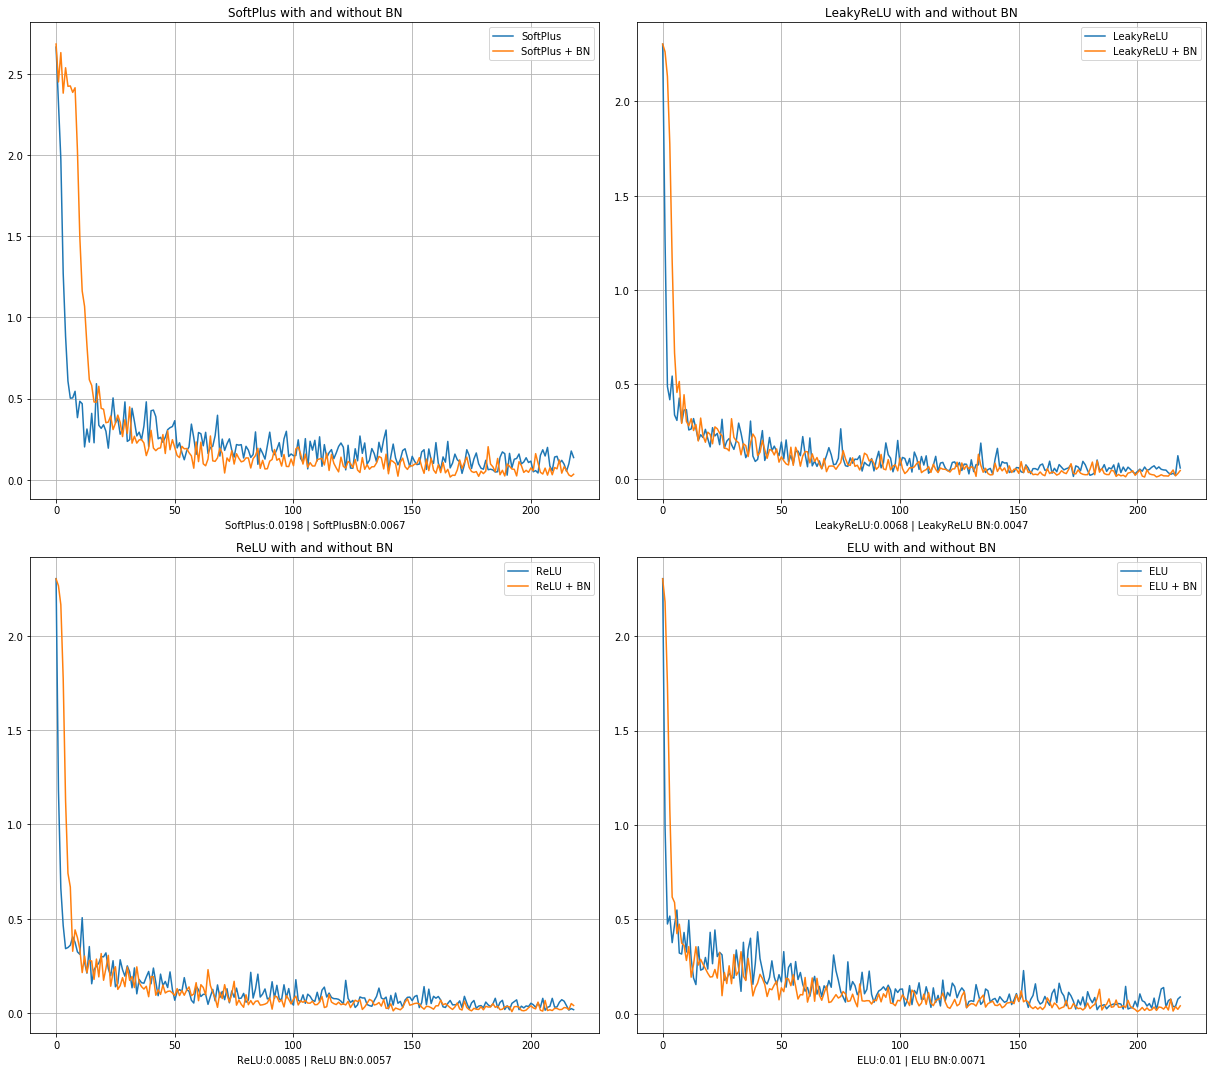

In [22]:
fig, ax = plt.subplots(2,2, figsize=(17,15))
ax[0,0].plot(loss_per_activation[0][::50], label='SoftPlus')
ax[0,0].plot(loss_per_activation_BN[0][::50], label='SoftPlus + BN')
ax[0,0].grid()
ax[0,0].set_xlabel('SoftPlus:'+str(round(min(loss_per_activation[0]),4)) + ' | SoftPlusBN:' + \
                 str(round(min(loss_per_activation_BN[0]),4)))
ax[0,0].legend()
#ax[0,0].set_yscale("log")
ax[0,0].set_title('SoftPlus with and without BN')

ax[0,1].plot(loss_per_activation[1][::50], label='LeakyReLU')
ax[0,1].plot(loss_per_activation_BN[1][::50], label='LeakyReLU + BN')
ax[0,1].grid()
ax[0,1].set_xlabel('LeakyReLU:'+str(round(min(loss_per_activation[1]),4)) + ' | LeakyReLU BN:' + \
                 str(round(min(loss_per_activation_BN[1]),4)))
ax[0,1].legend()
#ax[0,1].set_yscale("log")
ax[0,1].set_title('LeakyReLU with and without BN')

ax[1,0].plot(loss_per_activation[2][::50], label='ReLU')
ax[1,0].plot(loss_per_activation_BN[2][::50], label='ReLU + BN')
ax[1,0].grid()
ax[1,0].set_xlabel('ReLU:'+str(round(min(loss_per_activation[2]),4)) + ' | ReLU BN:' + \
                 str(round(min(loss_per_activation_BN[2]),4)))
ax[1,0].legend()
#ax[1,0].set_yscale("log")
ax[1,0].set_title('ReLU with and without BN')

ax[1,1].plot(loss_per_activation[3][::50], label='ELU')
ax[1,1].plot(loss_per_activation_BN[3][::50], label='ELU + BN')
ax[1,1].grid()
ax[1,1].set_xlabel('ELU:'+str(round(min(loss_per_activation[3]),4)) + ' | ELU BN:' + \
                 str(round(min(loss_per_activation_BN[3]),4)))
ax[1,1].legend()
#ax[1,1].set_yscale("log")
ax[1,1].set_title('ELU with and without BN')

plt.tight_layout();

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

We see that absolutely everywhere the team of an activation function + Batch Normalization outperforms thier colleagues with no Batch Normalization. Furthermore, Batch Normalization accelerates convergence. 

If talk about activations for this particular task ReLU and Leaky ReLU score. Leaky ReLU achives slightly better score, but a bit slower than common ReLU. SoftPlus and ELU require more time to proceed an epoch and are not able to perform as well as rectified linear (leaky) units.

My further choice is Leaky ReLU.

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [23]:
# Your code goes here. ################################################
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

In [24]:
net = Sequential()
net.add(Linear(28*28, 500))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(500))
net.add(ReLU())
net.add(ReLU())
net.add(ReLU())
net.add(Dropout(0.5))
net.add(Linear(500, 10))
net.add(LogSoftMax())

In [25]:
n_epoch = 20
batch_size = 256

In [26]:
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
criterion = ClassNLLCriterion()

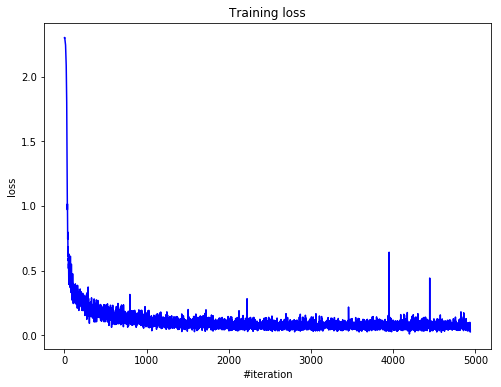

Current loss: 0.025377



In [27]:
loss_history = []

for i in tqdm_notebook(range(n_epoch)):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)
        
    if (i+1)%4==0:
        optimizer_config['learning_rate'] = optimizer_config['learning_rate']/5

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

We see that our loss is a bit rough, but it's absolutely okay if we are using dropout.

Print here your accuracy. It should be around 90%.

In [28]:
# Your answer goes here. ################################################
net.evaluate()

correct = 0
for x_batch, y_batch in get_batches((X_test, y_test), 2):
    predictions = net.forward(x_batch)
    true1, predicted1 = np.argmax(y_batch[0]), np.argmax(predictions[0])
    true2, predicted2 = np.argmax(y_batch[1]), np.argmax(predictions[1])
    correct+= int(true1 == predicted1)
    correct+= int(true2 == predicted2)

print('accuracy:', correct / y_test.shape[0])

accuracy: 0.9758571428571429


Cool. With this architecture and dropout we gained 96% accuracy (on only 10% validation set, of course, cuz this split was mentioned on the seminar).

# Autoencoder

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
<img src="autoencoder.png">

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use `MSECriterion` to score the reconstruction. Use `BatchNormalization` (followed by `ChannelwiseScaling` as usual) between `Linear` and `ReLU`. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [29]:
# Your code goes here. ################################################
net = Sequential()

net.add(Linear(28*28, 512))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(512))
net.add(LeakyReLU())

net.add(Linear(512, 256))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(256))
net.add(LeakyReLU())

net.add(Linear(256, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(LeakyReLU())

net.add(Linear(128, 30))
#bottleneck
net.add(Linear(30, 128))

net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(LeakyReLU())

net.add(Linear(128, 256))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(256))
net.add(LeakyReLU())

net.add(Linear(256, 512))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(512))
net.add(LeakyReLU())

net.add(Linear(512, 784))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(784))
net.add(LeakyReLU())

In [30]:
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
optimizer_state = {}
criterion = MSECriterion()
batch_size=256

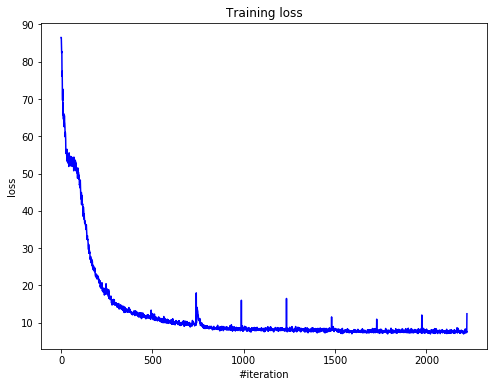

Current loss: 12.389124


In [31]:
loss_history = []

for i in range(9):
    for x_batch, y_batch in get_batches((X_train, X_train), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)
        
        loss_history.append(loss)
    if (i+1) % 3 == 0:
        optimizer_config['learning_rate'] = optimizer_config['learning_rate']/5 #I found if we decrease by 5 it's better

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [32]:
net[:13]

[Linear 784 -> 512,
 BatchNormalization,
 ChannelwiseScaling,
 LeakyReLU,
 Linear 512 -> 256,
 BatchNormalization,
 ChannelwiseScaling,
 LeakyReLU,
 Linear 256 -> 128,
 BatchNormalization,
 ChannelwiseScaling,
 LeakyReLU,
 Linear 128 -> 30]

In [33]:
net[13:]

[Linear 30 -> 128,
 BatchNormalization,
 ChannelwiseScaling,
 LeakyReLU,
 Linear 128 -> 256,
 BatchNormalization,
 ChannelwiseScaling,
 LeakyReLU,
 Linear 256 -> 512,
 BatchNormalization,
 ChannelwiseScaling,
 LeakyReLU,
 Linear 512 -> 784,
 BatchNormalization,
 ChannelwiseScaling,
 LeakyReLU]

In [34]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################
net.evaluate()
autoenc, decoder = Sequential(), Sequential()

autoenc.modules = deepcopy(net.modules[:13])
decoder.modules = deepcopy(net.modules[13:])

In [35]:
X_train_reduced = np.apply_along_axis(lambda x: autoenc.forward(x), axis=1, arr=X_train)
X_test_reduced = np.apply_along_axis(lambda x: autoenc.forward(x), axis=1, arr=X_test)

In [36]:
print('Train:',X_train.shape,'-->',X_train_reduced.shape)
print('Test:',X_test.shape,'-->',X_test_reduced.shape)

Train: (63000, 784) --> (63000, 30)
Test: (7000, 784) --> (7000, 30)


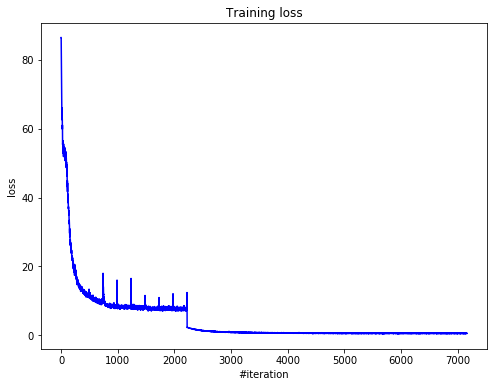

Current loss: 0.496491


In [37]:
# Now build a logistic regression or small classification net
cnet = Sequential()
cnet.add(Linear(30, 10))
cnet.add(LogSoftMax())

# Learn the weights
# Your code goes here. ################################################

optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
optimizer_state = {}
criterion = ClassNLLCriterion()
batch_size=256

for i in range(20):
    for x_batch, y_batch in get_batches((X_train_reduced, y_train), batch_size):
        
        cnet.zeroGradParameters()
        
        # Forward
        predictions = cnet.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        cnet.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(cnet.getParameters(),
                     cnet.getGradParameters(),
                     optimizer_config,
                     optimizer_state)
        
        loss_history.append(loss)
    if i == 10:
        optimizer_config['learning_rate'] = optimizer_config['learning_rate']/5
    if i == 16:
        optimizer_config['learning_rate'] = optimizer_config['learning_rate']/5 
        
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

In [38]:
# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# Your code goes here. ################################################

# As I already choped it long ago I'll just add these guys on top
autoenc.train()
autoenc.add(cnet[0])
autoenc.add(cnet[1])

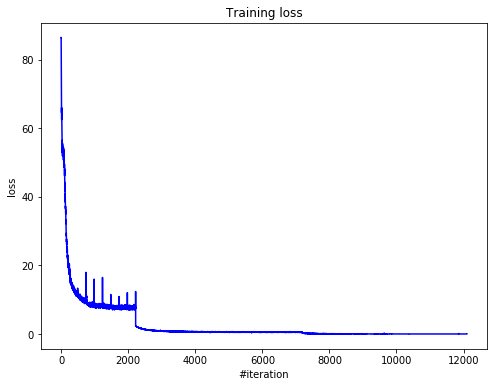

Current loss: 0.052011


In [39]:
# Now optimize whole model
# Your code goes here. ################################################
autoenc.train()

optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
optimizer_state = {}
criterion = ClassNLLCriterion()
batch_size=256

for i in range(20):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        autoenc.zeroGradParameters()
        
        # Forward
        predictions = autoenc.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        autoenc.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(autoenc.getParameters(),
                     autoenc.getGradParameters(),
                     optimizer_config,
                     optimizer_state)
        
        loss_history.append(loss)
    if i == 10:
        optimizer_config['learning_rate'] = optimizer_config['learning_rate']/5
    if i == 16:
        optimizer_config['learning_rate'] = optimizer_config['learning_rate']/5 
        
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

 - ##### Test:

In [40]:
# Your answer goes here. ################################################
autoenc.evaluate()

correct = 0
for x_batch, y_batch in get_batches((X_test, y_test), 2):
    predictions = autoenc.forward(x_batch)
    true1, predicted1 = np.argmax(y_batch[0]), np.argmax(predictions[0])
    true2, predicted2 = np.argmax(y_batch[1]), np.argmax(predictions[1])
    correct+= int(true1 == predicted1)
    correct+= int(true2 == predicted2)

print('accuracy:', correct / y_test.shape[0])

accuracy: 0.9718571428571429


In [41]:
### accuracy with a common feed-forward network was 0.9691428571428572, slightly better

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

I think that for real-world classifiers it's not the best pipeline to use. What we do is literally perform dimensionality reduction (DR) and then just logistic regression. Okay, maybe for some particular tasks DR really helps and easily performed by autoencoder, but for some modern task, it does not. Instead of this weird ensemble of autoencoder and log.reg. we can just use PCA/MDS/ISOMAPS/EIGENMAPS and many many other techniques. More than that there are a lot of tasks when dimensionality reduction cannot be done at all. In that case, we will end in a simple super high dimensional logistic regression.

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [42]:
pca = PCA(n_components=30)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [43]:
encoder = Sequential()
encoder.modules = deepcopy(autoenc.modules[:13])
encoder.evaluate()
decoder.evaluate()

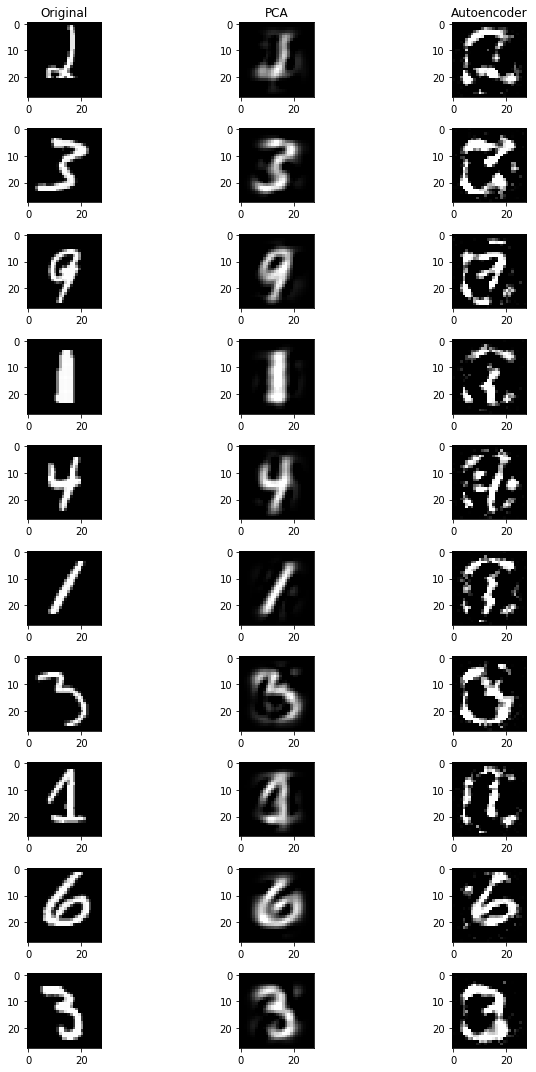

In [44]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################
fig, ax = plt.subplots(10,3, figsize=(10,15))
for i in range(10):
    cur_img = X_test[i].copy()
    for j in range(3):
        if j==0:
            ax[i,j].imshow(cur_img.reshape(28,28), cmap='gray')
        if j==1:
            cur_img_pca = pca.transform(cur_img.reshape(1,-1))
            cur_img_pca = np.clip(pca.inverse_transform(cur_img_pca),0,1)
            ax[i,j].imshow(cur_img_pca.reshape(28,28), cmap='gray')
        if j==2:
            cur_img_enc = encoder.forward(cur_img)
            cur_img_enc = np.clip(decoder.forward(cur_img_enc),0,1)
            ax[i,j].imshow(cur_img_enc.reshape(28,28), cmap='gray')
ax[0,0].set_title('Original')
ax[0,1].set_title('PCA')
ax[0,2].set_title('Autoencoder')
plt.tight_layout();